##Install Library and preparing

In [1]:
!pip install torch
!pip install tf
!pip install -q gdown
!pip install transformers[torch] accelerate -U
!pip install accelerate -U
!pip install datasets
!pip install gensim
!pip install evaluate

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re
import gc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from collections import Counter
import tensorflow as tf
from gensim.models import Word2Vec
from transformers import AutoTokenizer, AutoModelForSequenceClassification,Trainer, AutoConfig, TrainingArguments, EarlyStoppingCallback
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Dense, Flatten, concatenate, BatchNormalization,LSTM, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
from evaluate import load
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import he_normal
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import BorderlineSMOTE,KMeansSMOTE,SVMSMOTE

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.1 MB/s eta 0:00:00


###Read Dataset and load Word2Vec

In [2]:
df = pd.read_csv("/content/hoax_train_balanced_clean.csv")

In [3]:
df_test1 = pd.read_csv("/content/hoax_test_clean.csv")
# df_test2 = pd.read_csv("test_data_2.csv")
# df_test3 = pd.read_csv("test_data_3.csv")

In [4]:
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
gc.collect()
print(gensim.__version__)
# Load Pretrained Word Embeddings (Word2Vec)
!gdown --id 1QYj5FruufaPq2mZgC6lZlq2Uw2E004Og
!gdown --id 1F9QsHO7FPIPq3nL_I0zCkZFvq3OVcJrB
!gdown --id 1VUjxpH10baOw439V-YAAVVbtyI8iLgG5

4.4.0
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1QYj5FruufaPq2mZgC6lZlq2Uw2E004Og
To: /content/idwiki_word2vec_768_new_lower.model
100% 14.4M/14.4M [00:00<00:00, 118MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1F9QsHO7FPIPq3nL_I0zCkZFvq3OVcJrB
From (redirected): https://drive.google.com/uc?id=1F9QsHO7FPIPq3nL_I0zCkZFvq3OVcJrB&confirm=t&uuid=20bc8933-2c82-400c-8178-634538ea2176
To: /content/idwiki_word2vec_768_new_lower.model.syn1neg.npy
100% 1.37G/1.37G [00:20<00:00, 66.5MB/s]
/usr/local/lib/python3.12/dist-packages/gd

In [5]:
# import os
# import gdown
# import zipfile

# '''https://drive.google.com/file/d/1R0Rq2oQEH4N1K7eXLvGkvKosR2rzxIw3/view?usp=sharing'''

# file_id = '1R0Rq2oQEH4N1K7eXLvGkvKosR2rzxIw3'

# url = f'https://drive.google.com/uc?id={file_id}'
# output_zip = 'model_w2v.zip'

# if not os.path.exists('idwiki_word2vec_768_new_lower.model'):
#     print("Downloading Model...")
#     gdown.download(url, output_zip, quiet=False)

#     print("Extracting File...")
#     with zipfile.ZipFile(output_zip, 'r') as zip_ref:
#         zip_ref.extractall('/content/')
#     print("Done.")
# else:
#     print("Model Available")

In [6]:
word_embeddings = Word2Vec.load('/content/idwiki_word2vec_768_new_lower.model')
#word_embeddings = Word2Vec.load('/content/modelword2vec/idwiki_word2vec_768_new_lower.model')

###Split Dataset

In [7]:
x_train = df['Text']
y_train = df['Label']

In [8]:
x_test1 = df_test1['Text']
y_test1 = np.array(df_test1['Label'])

In [9]:
# x_test2 = df_test2['Text']
# y_test2 = np.array(df_test2['Label'])

In [10]:
# x_test3 = df_test3['Text']
# y_test3 = np.array(df_test3['Label'])

###Define Loss Function, Tokenization, Word Embeddings and Oversampling

In [11]:
# # Define the margin loss function
# def margin_loss(y_true, y_pred):
#     margin = K.constant(0.1)
#     y_true_float = K.cast(y_true, dtype='float32')  # Convert y_true to float32
#     squared_difference_pos = K.square(K.maximum(0.9 - y_pred, 0))
#     squared_difference_neg = K.square(K.maximum(y_pred - 0.1, 0))
#     loss_pos = K.mean(y_true_float * squared_difference_pos)
#     loss_neg = K.mean((1 - y_true_float) * squared_difference_neg)
#     total_loss = loss_pos + lambda_val * loss_neg
#     return total_loss

In [12]:
# Define the model architectures
#embedding_dim = 300
#max_sequence_length = 100
# lambda_val = 0.7  # Lambda value for margin loss
#num_words = 100000

In [13]:
# Create word index
word_index = {word: index + 1 for index, word in enumerate(word_embeddings.wv.index_to_key)}

# Create embedding matrix
embedding_dim = word_embeddings.vector_size
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in word_embeddings.wv:
        embedding_vector = word_embeddings.wv[word]
        embedding_matrix[i] = embedding_vector


In [14]:
# Tokenization
tokenizer = Tokenizer(num_words=len(word_index) + 1, oov_token='<OOV>')
tokenizer.fit_on_texts(x_train.astype(str))

# Convert text to sequences and pad
x_train_sequences = tokenizer.texts_to_sequences(x_train.astype(str))
# Convert all values in x_test1 to string before tokenization
x_test_sequences1 = tokenizer.texts_to_sequences(x_test1.astype(str))

# Determine max sequence length based on your data
max_sequence_length = max(max(len(seq) for seq in x_train_sequences), max(len(seq) for seq in x_test_sequences1))

x_train_padded = pad_sequences(x_train_sequences, maxlen=max_sequence_length, padding='post')
x_test_padded1 = pad_sequences(x_test_sequences1, maxlen=max_sequence_length, padding='post')

In [15]:
x_train_flat = x_train_padded.reshape(x_train_padded.shape[0], -1)

####Oversampling with BorderlineSMOTE

In [16]:
borderline_smote = BorderlineSMOTE(random_state=42)
x_train_resampled_flat_borderline, y_train_resampled_borderline = borderline_smote.fit_resample(x_train_flat, y_train)
x_train_resampled_borderline = x_train_resampled_flat_borderline.reshape(x_train_resampled_flat_borderline.shape[0], max_sequence_length)

####Oversampling with KMeansSMOTE

In [17]:
kmeans_smote = KMeansSMOTE(random_state=42, cluster_balance_threshold=0.2)
x_train_resampled_flat_kmeans, y_train_resampled_kmeans = kmeans_smote.fit_resample(x_train_flat, y_train)
x_train_resampled_kmeans = x_train_resampled_flat_kmeans.reshape(x_train_resampled_flat_kmeans.shape[0], max_sequence_length)

####Oversampling with SVMSMOTE

In [18]:
svm_smote = SVMSMOTE(random_state=42)
x_train_resampled_flat_svm, y_train_resampled_svm = svm_smote.fit_resample(x_train_flat, y_train)
x_train_resampled_svm = x_train_resampled_flat_svm.reshape(x_train_resampled_flat_svm.shape[0], max_sequence_length)

In [19]:
torch.cuda.empty_cache()
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [20]:
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


##CNN + LSTM

In [21]:
# Define the architecture of the hybrid model with he_normal initialization
static_input = Input(shape=(max_sequence_length,))
static_embedding = Embedding(len(word_index) + 1, embedding_dim, input_length=max_sequence_length, trainable=False)(static_input)  # Removed weights parameter

# CNN Layers
static_cnn_output = Conv1D(128, 3, activation='relu', kernel_initializer=he_normal())(static_embedding)  # Use he_normal initialization
static_cnn_output = MaxPooling1D(2)(static_cnn_output)
static_cnn_output = GlobalMaxPooling1D()(static_cnn_output)
static_cnn_output = Dropout(0.5)(static_cnn_output)
batch_norm_layer_cnn = BatchNormalization()(static_cnn_output)

# LSTM Layer
static_lstm_output = LSTM(128, kernel_initializer=he_normal())(static_embedding)  # Use he_normal initialization
static_lstm_output = Dropout(0.5)(static_lstm_output)
batch_norm_layer_lstm = BatchNormalization()(static_lstm_output)

# Concatenate CNN and LSTM outputs
merged_layer = tf.keras.layers.concatenate([batch_norm_layer_cnn, batch_norm_layer_lstm], axis=-1)

# Fully Connected Layers
static_dense_output = Dense(128, activation='relu', kernel_initializer=he_normal())(merged_layer)  # Use he_normal initialization
static_dense_output = Dropout(0.5)(static_dense_output)
output = Dense(1, activation='sigmoid')(static_dense_output)

# Create the hybrid model
hybrid_model = Model(inputs=static_input, outputs=output)
hybrid_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


###CNN + LSTM BorderlineSMOTE Train and Test

In [22]:
# Train the CNN + LSTM model
epochs_hybrid = 10
history_hybrid_borderline = hybrid_model.fit(
    x_train_resampled_borderline,
    y_train_resampled_borderline,
    batch_size=128,
    epochs=epochs_hybrid,
    validation_split=0.1,
)



Epoch 1/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - accuracy: 0.7494 - loss: 0.5051 - val_accuracy: 0.9324 - val_loss: 0.4169
Epoch 2/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.9708 - loss: 0.0878 - val_accuracy: 0.9878 - val_loss: 0.1363
Epoch 3/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.9864 - loss: 0.0404 - val_accuracy: 0.9978 - val_loss: 0.0138
Epoch 4/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.9920 - loss: 0.0237 - val_accuracy: 0.9974 - val_loss: 0.0057
Epoch 5/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.9949 - loss: 0.0172 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 6/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.9955 - loss: 0.0126 - val_accuracy: 1.0000 - val_loss: 4.1202e-04
Epoch 7/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.9959 - loss: 0.0134 - val_accuracy: 0.9996 - val_loss: 7.1197e-04
Epoch 8/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.9950 - loss: 0.0138 

####Testing

In [24]:
hybrid_evaluation1 = hybrid_model.evaluate(x_test_padded1, y_test1.reshape(-1, 1), batch_size=4)
hybrid_accuracy1 = hybrid_evaluation1[1]

print("Hybrid Model Evaluation Results:")
print("Accuracy:", hybrid_accuracy1)

403/403 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9192 - loss: 0.3324
Hybrid Model Evaluation Results:
Accuracy: 0.9211669564247131


In [25]:
y_test_pred1 = (hybrid_model.predict(x_test_padded1) > 0.5).astype("int32").flatten()

test_report1 = classification_report(y_test1, y_test_pred1)

print("Classification Report on Test Dataset 1 :")
print(test_report1)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Classification Report on Test Dataset 1 :
              precision    recall  f1-score   support

           0       0.98      0.64      0.77       336
           1       0.91      1.00      0.95      1275

    accuracy                           0.92      1611
   macro avg       0.94      0.82      0.86      1611
weighted avg       0.93      0.92      0.91      1611



###CNN + LSTM KMeansSMOTE Train and Test

In [26]:
hybrid_model = Model(inputs=static_input, outputs=output)
hybrid_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
# Train the CNN + LSTM model
epochs_hybrid = 10
history_hybrid_kmeans = hybrid_model.fit(
    x_train_resampled_kmeans,
    y_train_resampled_kmeans,
    batch_size=128,
    epochs=epochs_hybrid,
    validation_split=0.1,
)



Epoch 1/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.9965 - loss: 0.0095 - val_accuracy: 1.0000 - val_loss: 1.4092e-04
Epoch 2/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.9953 - loss: 0.0136 - val_accuracy: 1.0000 - val_loss: 8.2771e-05
Epoch 3/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.9955 - loss: 0.0130 - val_accuracy: 1.0000 - val_loss: 3.6360e-05
Epoch 4/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.9969 - loss: 0.0093 - val_accuracy: 1.0000 - val_loss: 1.3376e-04
Epoch 5/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.9961 - loss: 0.0114 - val_accuracy: 1.0000 - val_loss: 1.6668e-04
Epoch 6/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.9965 - loss: 0.0109 - val_accuracy: 1.0000 - val_loss: 5.0345e-05
Epoch 7/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.9983 - loss: 0.0054 - val_accuracy: 1.0000 - val_loss: 5.7038e-05
Epoch 8/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accura

####Testing

In [28]:
hybrid_evaluation1 = hybrid_model.evaluate(x_test_padded1, y_test1.reshape(-1, 1), batch_size=4)
hybrid_accuracy1 = hybrid_evaluation1[1]

print("Hybrid Model Evaluation Results:")
print("Accuracy:", hybrid_accuracy1)

403/403 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9361 - loss: 0.3206
Hybrid Model Evaluation Results:
Accuracy: 0.9304779767990112


In [29]:
y_test_pred1 = (hybrid_model.predict(x_test_padded1) > 0.5).astype("int32").flatten()

test_report1 = classification_report(y_test1, y_test_pred1)

print("Classification Report on Test Dataset 1 :")
print(test_report1)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Classification Report on Test Dataset 1 :
              precision    recall  f1-score   support

           0       0.99      0.68      0.80       336
           1       0.92      1.00      0.96      1275

    accuracy                           0.93      1611
   macro avg       0.95      0.84      0.88      1611
weighted avg       0.93      0.93      0.93      1611



###CNN + LSTM SVMSMOTE Train and Test

In [30]:
hybrid_model = Model(inputs=static_input, outputs=output)
hybrid_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
# Train the CNN + LSTM model
epochs_hybrid = 10
history_hybrid_svm = hybrid_model.fit(
    x_train_resampled_svm,
    y_train_resampled_svm,
    batch_size=128,
    epochs=epochs_hybrid,
    validation_split=0.1,
)



Epoch 1/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.9976 - loss: 0.0077 - val_accuracy: 1.0000 - val_loss: 1.0100e-04
Epoch 2/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.9977 - loss: 0.0073 - val_accuracy: 1.0000 - val_loss: 5.8024e-05
Epoch 3/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.9977 - loss: 0.0070 - val_accuracy: 1.0000 - val_loss: 1.3436e-04
Epoch 4/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.9979 - loss: 0.0060 - val_accuracy: 1.0000 - val_loss: 7.2046e-05
Epoch 5/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.9971 - loss: 0.0069 - val_accuracy: 1.0000 - val_loss: 1.7805e-05
Epoch 6/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.9982 - loss: 0.0057 - val_accuracy: 1.0000 - val_loss: 1.3876e-05
Epoch 7/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.9978 - loss: 0.0054 - val_accuracy: 1.0000 - val_loss: 1.2574e-05
Epoch 8/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accura

####Testing

In [32]:
hybrid_evaluation1 = hybrid_model.evaluate(x_test_padded1, y_test1.reshape(-1, 1), batch_size=4)
hybrid_accuracy1 = hybrid_evaluation1[1]

print("Hybrid Model Evaluation Results:")
print("Accuracy:", hybrid_accuracy1)

403/403 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9189 - loss: 0.4182
Hybrid Model Evaluation Results:
Accuracy: 0.9112352728843689


In [33]:
y_test_pred1 = (hybrid_model.predict(x_test_padded1) > 0.5).astype("int32").flatten()

test_report1 = classification_report(y_test1, y_test_pred1)

print("Classification Report on Test Dataset 1 :")
print(test_report1)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Classification Report on Test Dataset 1 :
              precision    recall  f1-score   support

           0       0.98      0.59      0.73       336
           1       0.90      1.00      0.95      1275

    accuracy                           0.91      1611
   macro avg       0.94      0.79      0.84      1611
weighted avg       0.92      0.91      0.90      1611



##Evaluation

In [34]:
torch.cuda.empty_cache()

In [35]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt

def show_confusion_matrix(confusion_matrix):
        hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
        hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')

        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

###Hybrid

####BorderlineSMOTE

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


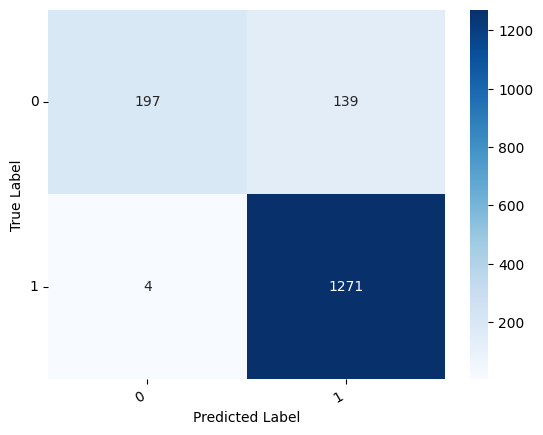

In [36]:
predictions_hybrid_1 = hybrid_model.predict(x_test_padded1)
predicted_labels_hybrid_1 = (predictions_hybrid_1 > 0.5).astype(int)
cm_hybrid_1 = confusion_matrix(y_test1,predicted_labels_hybrid_1)
show_confusion_matrix(cm_hybrid_1)

####KMeansSMOTE

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


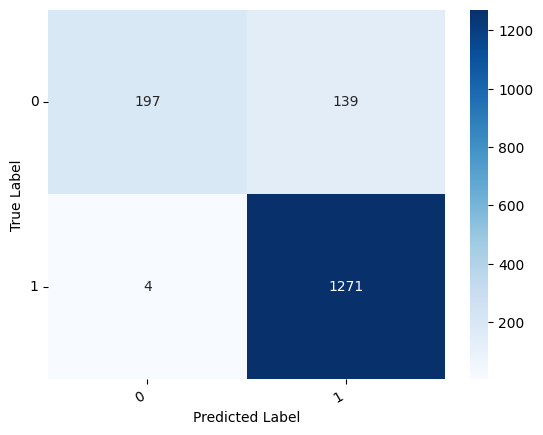

In [37]:
predictions_hybrid_1 = hybrid_model.predict(x_test_padded1)
predicted_labels_hybrid_1 = (predictions_hybrid_1 > 0.5).astype(int)
cm_hybrid_1 = confusion_matrix(y_test1,predicted_labels_hybrid_1)
show_confusion_matrix(cm_hybrid_1)

####SVMSMOTE

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


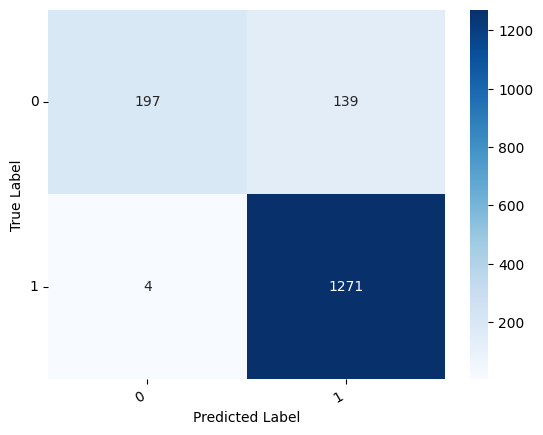

In [38]:
predictions_hybrid_1 = hybrid_model.predict(x_test_padded1)
predicted_labels_hybrid_1 = (predictions_hybrid_1 > 0.5).astype(int)
cm_hybrid_1 = confusion_matrix(y_test1,predicted_labels_hybrid_1)
show_confusion_matrix(cm_hybrid_1)